# Loading Dataset

In [1]:
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf

In [2]:
(img_tr, lbs_tr), (img_ts, lbs_ts) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
img_tr = np.array(img_tr)
lbs_tr = np.array(lbs_tr)

img_ts = np.array(img_ts)
lbs_ts = np.array(lbs_ts)

ds = np.concatenate([img_tr, img_ts], axis=0)
lbs = np.concatenate([lbs_tr, lbs_ts], axis=0)

print(img_tr.shape)
print(ds.shape)

(50000, 32, 32, 3)
(60000, 32, 32, 3)


In [4]:
def plot_image(index):
  plt.imshow(ds[index])
  plt.show()

# Pre-processing

Basic Ideas:

1. Flipping and rotation (10k each)
2. Cropping (10 each)
3. Adding Noise (10k)

Advanced Ideas:

1. Cutout (10k)
2. Mixup (10k)
3. One pixel attack

In [5]:
## Dataset split

# Flip
to_flip = ds[:10000]
to_flip_labels = lbs[:10000]

# Rotate
to_rotate = ds[10000:20000]
to_rotate_labels = lbs[10000:20000]

# Crop
to_crop = ds[20000:30000]
to_crop_labels = lbs[20000:30000]

# Noise
to_noise = ds[30000:40000]
to_noise_labels = lbs[30000:40000]

# Cutout
to_cutout = ds[40000:50000]
to_cutout_labels = lbs[40000:50000]

# Mixup
to_mix = ds[50000:]
to_mix_labels = lbs[50000:]

In [6]:
def flip(data_to_flip):
  flipped_images = data_to_flip
  for i in range(len(data_to_flip)):
    flipped_images[i] = cv2.flip(data_to_flip[i], 1)
  return flipped_images

flipped_data, flipped_labels = flip(to_flip), to_flip_labels
# plt.imshow(flipped_data[0])
# plt.show()

# im = cv2.flip(dataset[0], 1)

# plt.imshow(im)
# plt.show()

# plot_image(0)

In [7]:
def rotate(data_to_rotate):
  rotated_images = []

  angles = [-30, -15, -10, 10, 15, 30]
  np.random.seed(32)
  angles_to_rotate = np.random.choice(angles, len(data_to_rotate))

  for i in range(len(data_to_rotate)):
    img = data_to_rotate[i]
    angle = angles_to_rotate[i]

    height, width = 32, 32
    center_x, center_y = 16, 16

    T = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
    rotated_images.append(cv2.warpAffine(img, T, (width, height)))
  return np.array(rotated_images)

rotated_data, rotated_labels = rotate(to_rotate), to_rotate_labels
# plt.imshow(rotated_data[1])
# plt.show()

# plot_image(10001)

In [8]:
def crop_and_resize(data_to_crop):
  cropped_images = []

  for img in data_to_crop:
    cropped_image = img[8:24, 8:24]
    resized_image = cv2.resize(cropped_image, (32, 32), interpolation=cv2.INTER_CUBIC)
    cropped_images.append(resized_image)
  return np.array(cropped_images)

cropped_data, cropped_labels = crop_and_resize(to_crop), to_crop_labels
# plt.imshow(cropped_data[0])
# plt.show()

# plot_image(20000)

In [9]:
def add_noise(data_to_add_noise):
    noisy_images = []
    np.random.seed(32)

    for img in data_to_add_noise:
        noise = np.random.normal(0, 5, img.shape)
        noised_img = img + noise
        noised_img = np.clip(noised_img, 0, 255)
        noised_img = noised_img.astype(np.uint8)

        noisy_images.append(noised_img)

    return np.array(noisy_images)

noised_data, noised_labels = add_noise(to_noise), to_noise_labels
# plt.imshow(noised_data[0])
# plt.show()

# plot_image(30000)

In [10]:
def cutout(data_to_cutout):
  cutout_images = []

  size = 6
  #cutout_square = np.zeros([size, size, 3])
  np.random.seed(32)

  for img in data_to_cutout:
    x, y = np.random.randint(0, 32-size, 2)

    img[x:x+size, y:y+size, :] = 0
    cutout_images.append(img)

  return np.array(cutout_images)

cutout_data, cutout_labels = cutout(to_cutout), to_cutout_labels
# plt.imshow(cutout_data[2])
# plt.show()

# plot_image(40007)

In [11]:
def mixup(data_to_mixup):
  alpha = 0.75
  mixup_images = []
  np.random.seed(32)

  for i in range(len(data_to_mixup)):
    img = data_to_mixup[i]

    j = np.random.randint(0, len(data_to_mixup))
    img_to_mix = data_to_mixup[j]

    mixed_img = alpha*img + (1-alpha)*img_to_mix
    mixed_img = np.clip(mixed_img, 0, 255)
    mixed_img = mixed_img.astype(np.uint8)

    mixup_images.append(mixed_img)

  return np.array(mixup_images)

mixed_data, mixed_labels = mixup(to_mix), to_mix_labels
# plt.imshow(mixed_data[453])
# plt.show()

# plot_image(50453)

In [12]:
dataset = np.concatenate([ds, flipped_data, rotated_data, cropped_data, noised_data, cutout_data, mixed_data], axis=0)
labels = np.concatenate([lbs, flipped_labels, rotated_labels, cropped_labels, noised_labels, cutout_labels, mixed_labels], axis=0)
## Normalisation
dataset = dataset / 255.0
# since for rotation, we need integer, we will normalise after pre-processing

In [13]:
## Train, Validation and Test Split
## train -> 95,000
## validation -> 10,000
## test -> 15,000

train_images, train_labels = dataset[:95000], labels[:95000]
val_images, val_labels = dataset[95000:105000], labels[95000:105000]
test_images, test_labels = dataset[105000:], labels[105000:]

# ANN

In [ ]:
model_ann = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=(32, 32, 3)), ## 32*32*3 = 3072
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'), #no of neurons doubled due to higher test accuracy than training and new layers got added.
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_ann = model_ann.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), batch_size=128)

model_ann.evaluate(test_images, test_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2536 - loss: 2.0862 - val_accuracy: 0.3981 - val_loss: 1.6792
Epoch 2/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3936 - loss: 1.6859 - val_accuracy: 0.4287 - val_loss: 1.6026
Epoch 3/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4359 - loss: 1.5695 - val_accuracy: 0.4551 - val_loss: 1.5292
Epoch 4/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4602 - loss: 1.5097 - val_accuracy: 0.4736 - val_loss: 1.4743
Epoch 5/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4803 - loss: 1.4559 - val_accuracy: 0.4801 - val_loss: 1.4703
Epoch 6/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4901 - loss: 1.4178 - val_accuracy: 0.4946 - val_loss: 1.3930
Epoch 7/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5117 - loss: 1.3672 - val_accuracy: 0.5313 - val_loss: 1.3179
Epoch 8/20
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5262 - loss: 1.3283 - val_accuracy: 0

[1.1586171388626099, 0.6033333539962769]

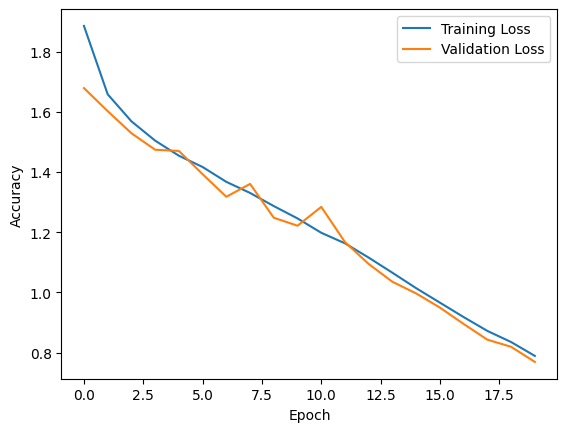

In [ ]:
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN

In [14]:
model_cnn = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='valid'), ## 32*32*3 to 32*32*32
        keras.layers.MaxPooling2D((2, 2)), ## 32*32*32 to 16*16*32

        keras.layers.Conv2D(64, (5, 5), activation='relu', padding='valid'), ## 16*16*32 to 14*14*64
        keras.layers.MaxPooling2D((2, 2)), ## 14*14*64 to 7*7*64

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='valid'), ## 7*7*64 to 7*7*128

        keras.layers.Flatten(), ## 7*7*128 = 6272
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(train_images, train_labels, epochs=15, validation_data=(val_images, val_labels), batch_size=256)

model_cnn.evaluate(test_images, test_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.3192 - loss: 1.8257 - val_accuracy: 0.5380 - val_loss: 1.2884
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5547 - loss: 1.2457 - val_accuracy: 0.5978 - val_loss: 1.1342
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6289 - loss: 1.0507 - val_accuracy: 0.6544 - val_loss: 0.9589
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6856 - loss: 0.8931 - val_accuracy: 0.7445 - val_loss: 0.7224
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7452 - loss: 0.7242 - val_accuracy: 0.7935 - val_loss: 0.5991
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8011 - loss: 0.5730 - val_accuracy: 0.8386 - val_loss: 0.4643
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8474 - loss: 0.4388 - val_accuracy: 0.8813 - val_loss: 0.3407
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8931 - loss: 0.3132 - val_a

[0.5354151129722595, 0.8613333106040955]

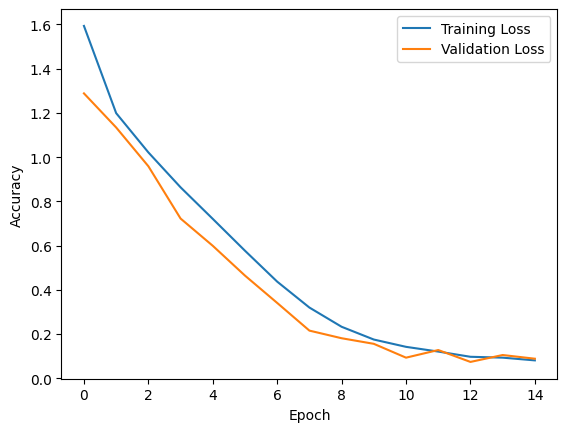

In [15]:
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# One pixel attack

In [16]:
def one_pixel_attack(test_data, labels, model, batch_size=256):
    correct_pred = 0

    np.random.seed(32)
    infected_data = np.copy(test_data)

    # Infect the dataset
    for i in range(len(test_data)):
        coord = np.random.randint(0, 32, 2)
        infected_data[i, coord[0], coord[1], :] = 0

    # Predict in batches
    for i in range(0, len(test_data), batch_size):
        batch_images = infected_data[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        batch_preds = model.predict(batch_images, verbose=0)
        batch_preds = np.argmax(batch_preds, axis=1)

        for i in range(len(batch_preds)):
          if batch_preds[i] == batch_labels[i]:
            correct_pred += 1

    return correct_pred / len(test_data)

In [17]:
one_pixel_attack(test_images, test_labels, model_cnn)

0.843

# Without pre-processing

In [18]:
## ANN
model_ann_without_pp = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=(32, 32, 3)), ## 32*32*3 = 3072
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'), #no of neurons doubled due to underfitting and new layers got added.
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model_ann_without_pp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_ann_without_pp.fit(img_tr, lbs_tr, epochs=20, batch_size=128)

model_ann_without_pp.evaluate(img_ts, lbs_ts)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1764 - loss: 192.5728
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3281 - loss: 1.9206
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3685 - loss: 1.7916
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4040 - loss: 1.6968
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4141 - loss: 1.6505
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4289 - loss: 1.6159
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4376 - loss: 1.5935
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4269 - loss: 1.6178
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4427 - loss: 1.5682
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4447 - loss: 1.5621
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4545 - loss: 1.5468
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

[1.5541332960128784, 0.44449999928474426]

In [19]:
## CNN
model_cnn_without_pp = keras.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='valid'), ## 32*32*3 to 32*32*32
        keras.layers.MaxPooling2D((2, 2)), ## 32*32*32 to 16*16*32

        keras.layers.Conv2D(64, (5, 5), activation='relu', padding='valid'), ## 16*16*32 to 14*14*64
        keras.layers.MaxPooling2D((2, 2)), ## 14*14*64 to 7*7*64

        keras.layers.Conv2D(128, (3,3), activation='relu', padding='valid'), ## 7*7*64 to 7*7*128

        keras.layers.Flatten(), ## 7*7*128 = 6272
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model_cnn_without_pp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn_without_pp.fit(img_tr, lbs_tr, epochs=15, batch_size=256)

model_cnn_without_pp.evaluate(img_ts, lbs_ts)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1260 - loss: 5.1147
Epoch 2/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2919 - loss: 1.8043
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4495 - loss: 1.4742
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5496 - loss: 1.2520
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6090 - loss: 1.0987
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6700 - loss: 0.9320
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7162 - loss: 0.7970
Epoch 8/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7590 - loss: 0.6782
Epoch 9/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8057 - loss: 0.5491
Epoch 10/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8435 - loss: 0.4444
Epoch 11/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8769 - loss: 0.3582
Epoch 12/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 

[1.766332983970642, 0.6341000199317932]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
EPOCHS = 15
BATCH_SIZE = 128
INPUT_SHAPE = (32, 32, 3)
num_classes=10
# Convert labels to one-hot encoding
y_train_cat = keras.utils.to_categorical(train_labels, num_classes)
y_val_cat = keras.utils.to_categorical(val_labels, num_classes)
y_test_cat = keras.utils.to_categorical(test_labels, num_classes)

**LeNet**

In [ ]:
def build_lenet():
    return models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=INPUT_SHAPE, padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

model_lenet = build_lenet()
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_lenet = model_lenet.fit(train_images, y_train_cat, epochs=EPOCHS,
                                validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)


# Evaluation
model_lenet.evaluate(test_images, y_test_cat)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3201 - loss: 1.8620 - val_accuracy: 0.4621 - val_loss: 1.4924
Epoch 2/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4767 - loss: 1.4545 - val_accuracy: 0.5091 - val_loss: 1.3933
Epoch 3/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5179 - loss: 1.3439 - val_accuracy: 0.5543 - val_loss: 1.2620
Epoch 4/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5505 - loss: 1.2583 - val_accuracy: 0.5828 - val_loss: 1.1834
Epoch 5/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5772 - loss: 1.1922 - val_accuracy: 0.6069 - val_loss: 1.1272
Epoch 6/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5990 - loss: 1.1344 - val_accuracy: 0.6259 - val_loss: 1.0712
Epoch 7/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6196 - loss: 1.0806 - val_accuracy: 0.6333 - val_loss: 1.0561
Epoch 8/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6339 - loss: 1.0391 - val_accuracy: 0

[1.0365478992462158, 0.6370000243186951]

In [ ]:
!pip install scikit-learn
from sklearn.metrics import roc_auc_score
def plot_history(history, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_predictions(model, x_test, y_test, model_name):

    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Predictions
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print(f"{model_name} - Classification Report")
    print(classification_report(y_true, y_pred))

    #ROC_AUC
    roc_auc = roc_auc_score(y_test_cat, y_pred_probs, average='macro', multi_class='ovr')
    print(f"ROC AUC Score (OvA): {roc_auc:.4f}")

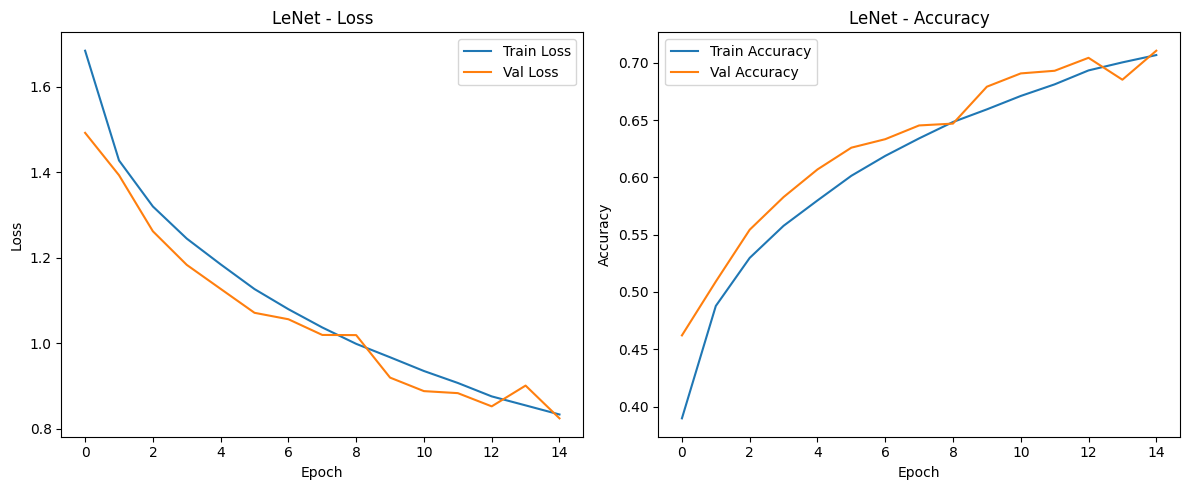

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


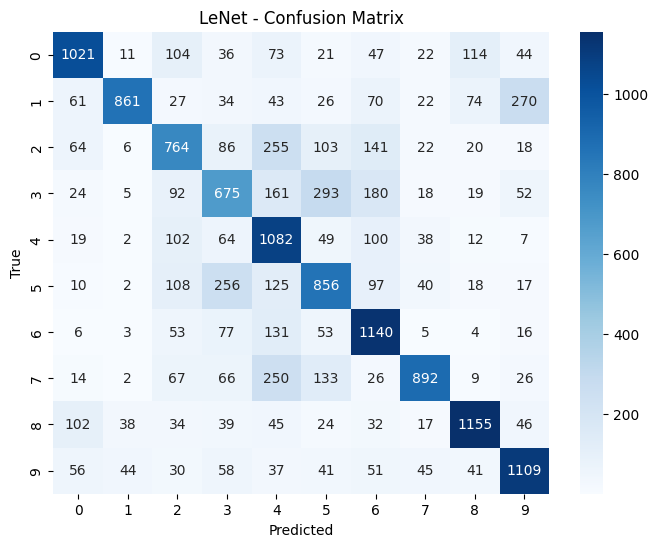

LeNet - Classification Report
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1493
           1       0.88      0.58      0.70      1488
           2       0.55      0.52      0.53      1479
           3       0.49      0.44      0.46      1519
           4       0.49      0.73      0.59      1475
           5       0.54      0.56      0.55      1529
           6       0.61      0.77      0.68      1488
           7       0.80      0.60      0.68      1485
           8       0.79      0.75      0.77      1532
           9       0.69      0.73      0.71      1512

    accuracy                           0.64     15000
   macro avg       0.66      0.64      0.64     15000
weighted avg       0.66      0.64      0.64     15000

ROC AUC Score (OvA): 0.9401


In [ ]:
plot_history(history_lenet, "LeNet")
evaluate_predictions(model_lenet, test_images, y_test_cat, "LeNet")

**AlexNet**

In [ ]:
def build_alexnet():
    return models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

model_alexnet = build_alexnet()
model_alexnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_alexnet = model_alexnet.fit(train_images, y_train_cat, epochs=5,
                                    validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)

# Evaluation
model_alexnet.evaluate(test_images, y_test_cat)

Epoch 1/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.2982 - loss: 1.8770 - val_accuracy: 0.5783 - val_loss: 1.1766
Epoch 2/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.5870 - loss: 1.1642 - val_accuracy: 0.6961 - val_loss: 0.8723
Epoch 3/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.6740 - loss: 0.9336 - val_accuracy: 0.7375 - val_loss: 0.7654
Epoch 4/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.7185 - loss: 0.8037 - val_accuracy: 0.7672 - val_loss: 0.6717
Epoch 5/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.7524 - loss: 0.7063 - val_accuracy: 0.8040 - val_loss: 0.5517
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7886 - loss: 0.6169


[0.7360312342643738, 0.7476666569709778]

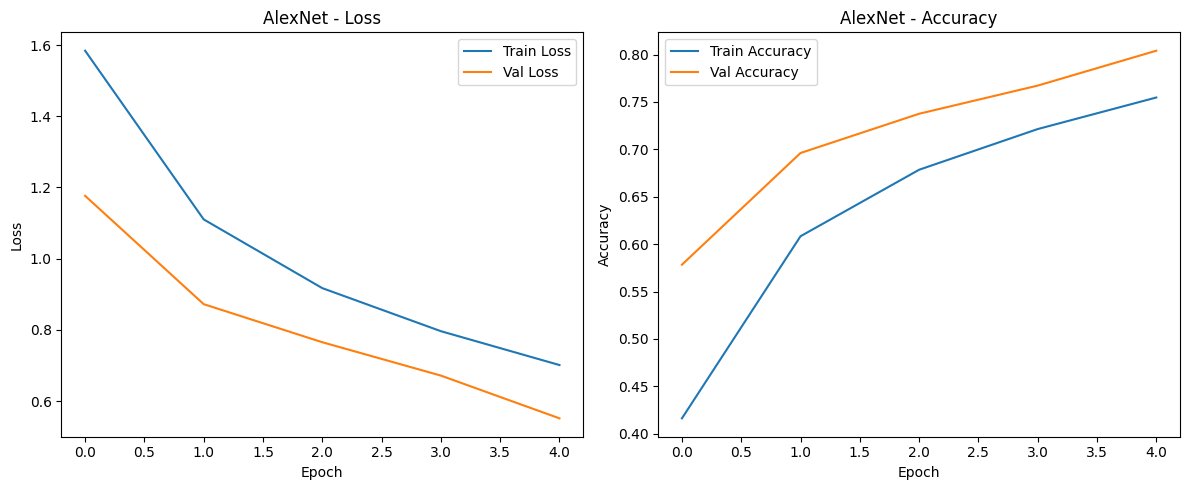

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


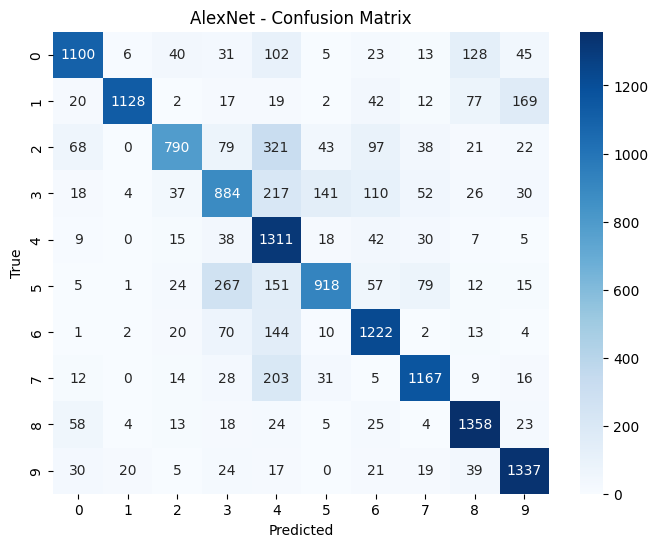

AlexNet - Classification Report
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1493
           1       0.97      0.76      0.85      1488
           2       0.82      0.53      0.65      1479
           3       0.61      0.58      0.59      1519
           4       0.52      0.89      0.66      1475
           5       0.78      0.60      0.68      1529
           6       0.74      0.82      0.78      1488
           7       0.82      0.79      0.80      1485
           8       0.80      0.89      0.84      1532
           9       0.80      0.88      0.84      1512

    accuracy                           0.75     15000
   macro avg       0.77      0.75      0.75     15000
weighted avg       0.77      0.75      0.75     15000

ROC AUC Score (OvA): 0.9706


In [ ]:
plot_history(history_alexnet, "AlexNet")
evaluate_predictions(model_alexnet, test_images, y_test_cat, "AlexNet")

**VGG16**

In [ ]:
def build_vgg16():
    return models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

model_vgg16 = build_vgg16()
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16 = model_vgg16.fit(train_images, y_train_cat, epochs=5,
                                validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)

# Evaluation
model_vgg16.evaluate(test_images, y_test_cat)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.2124 - loss: 2.0649 - val_accuracy: 0.4960 - val_loss: 1.3794
Epoch 2/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.5090 - loss: 1.3566 - val_accuracy: 0.5912 - val_loss: 1.1246
Epoch 3/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.6102 - loss: 1.1087 - val_accuracy: 0.6908 - val_loss: 0.8813
Epoch 4/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.6749 - loss: 0.9385 - val_accuracy: 0.7274 - val_loss: 0.7764
Epoch 5/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.7206 - loss: 0.8108 - val_accuracy: 0.7790 - val_loss: 0.6396
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7599 - loss: 0.6906


[0.7868146300315857, 0.7280666828155518]

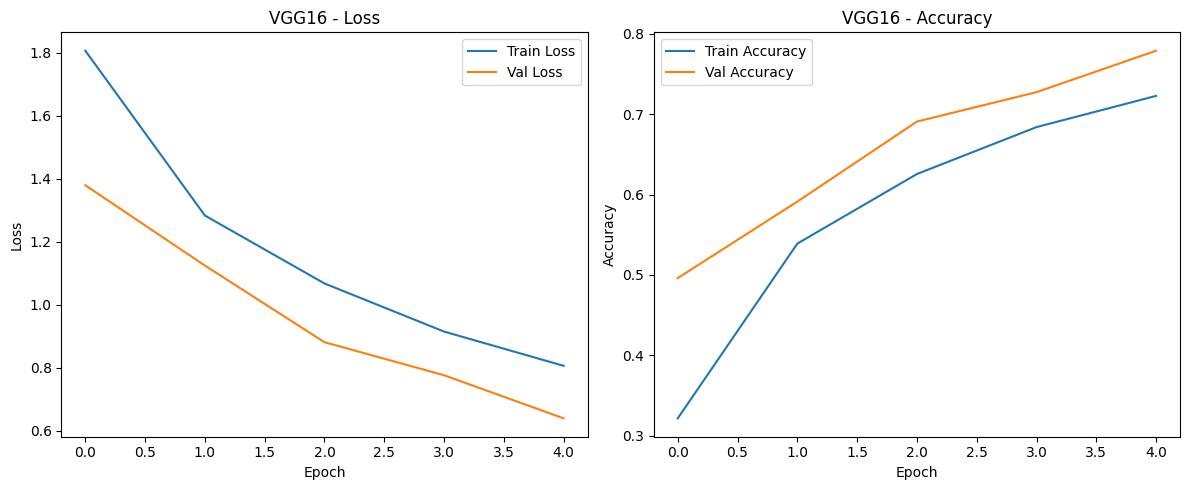

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


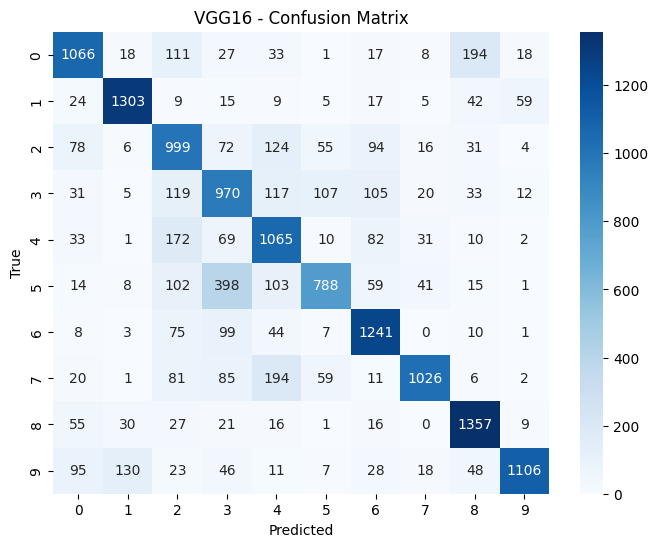

VGG16 - Classification Report
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1493
           1       0.87      0.88      0.87      1488
           2       0.58      0.68      0.62      1479
           3       0.54      0.64      0.58      1519
           4       0.62      0.72      0.67      1475
           5       0.76      0.52      0.61      1529
           6       0.74      0.83      0.79      1488
           7       0.88      0.69      0.77      1485
           8       0.78      0.89      0.83      1532
           9       0.91      0.73      0.81      1512

    accuracy                           0.73     15000
   macro avg       0.74      0.73      0.73     15000
weighted avg       0.74      0.73      0.73     15000

ROC AUC Score (OvA): 0.9636


In [ ]:
plot_history(history_vgg16, "VGG16")
evaluate_predictions(model_vgg16, test_images, y_test_cat, "VGG16")

In [ ]:
from tensorflow.keras.applications import VGG19, ResNet50, ResNet152

IMG_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

def build_transfer_model(BaseModel):
    # 1. Load base with pretrained ImageNet weights, exclude its top classification head
    base = BaseModel(include_top=False,
                     weights='imagenet',
                     input_shape=IMG_SHAPE)
    # 2. Freeze all layers
    base.trainable = False

    # 3. Append only a new classification head
    x = layers.GlobalAveragePooling2D(name='gap')(base.output)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)

    model = models.Model(inputs=base.input, outputs=outputs, name=BaseModel.__name__)
    return model

# Instantiate
vgg19_tl   = build_transfer_model(VGG19)
resnet50_tl  = build_transfer_model(ResNet50)
resnet152_tl = build_transfer_model(ResNet152)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


VGG 19

In [ ]:
vgg19_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg19 = vgg19_tl.fit(train_images, y_train_cat, epochs=5,
                                validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)

# Evaluation
vgg19_tl.evaluate(test_images, y_test_cat)

Epoch 1/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5271 - loss: 1.3625 - val_accuracy: 0.5239 - val_loss: 1.3522
Epoch 2/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.5346 - loss: 1.3445 - val_accuracy: 0.5304 - val_loss: 1.3398
Epoch 3/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.5406 - loss: 1.3257 - val_accuracy: 0.5372 - val_loss: 1.3222
Epoch 4/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5450 - loss: 1.3145 - val_accuracy: 0.5391 - val_loss: 1.3136
Epoch 5/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5461 - loss: 1.3056 - val_accuracy: 0.5451 - val_loss: 1.3066
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7599 - loss: 0.6906


[0.7868146300315857, 0.7280666828155518]

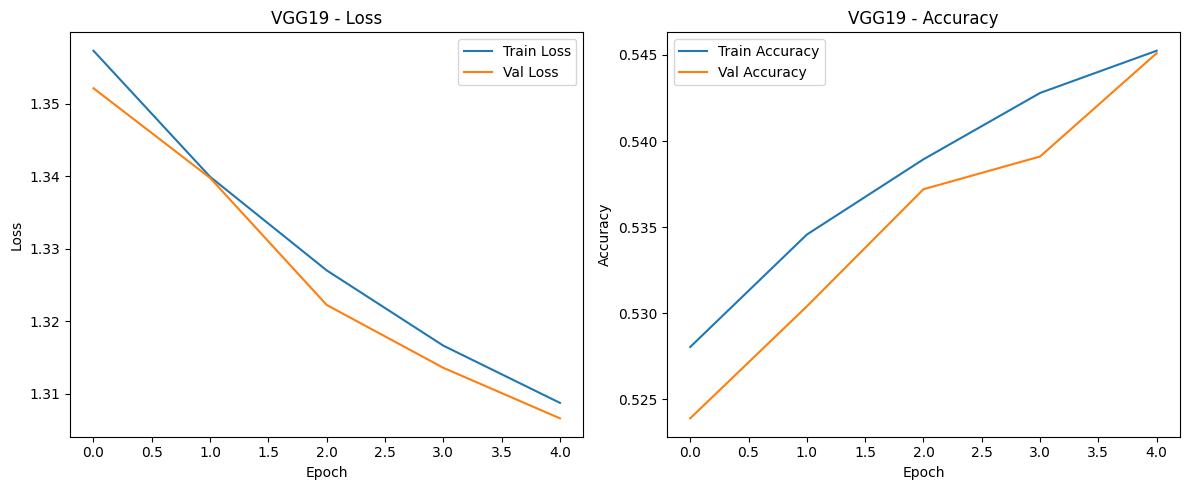

469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step


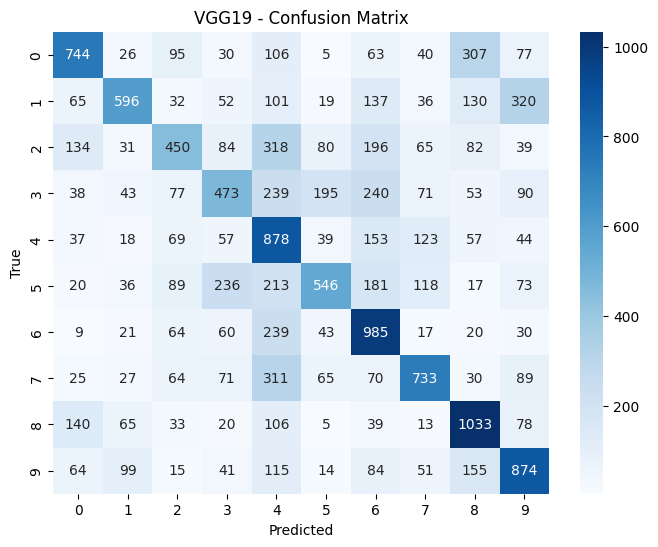

VGG19 - Classification Report
              precision    recall  f1-score   support

           0       0.58      0.50      0.54      1493
           1       0.62      0.40      0.49      1488
           2       0.46      0.30      0.36      1479
           3       0.42      0.31      0.36      1519
           4       0.33      0.60      0.43      1475
           5       0.54      0.36      0.43      1529
           6       0.46      0.66      0.54      1488
           7       0.58      0.49      0.53      1485
           8       0.55      0.67      0.60      1532
           9       0.51      0.58      0.54      1512

    accuracy                           0.49     15000
   macro avg       0.50      0.49      0.48     15000
weighted avg       0.51      0.49      0.48     15000

ROC AUC Score (OvA): 0.8785


In [ ]:
plot_history(history_vgg19, "VGG19")
evaluate_predictions(vgg19_tl, test_images, y_test_cat, "VGG19")

# ResNet-50

In [ ]:
resnet50_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50 = resnet50_tl.fit(train_images, y_train_cat, epochs=15,
                                validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)

# Evaluation
resnet50_tl.evaluate(test_images, y_test_cat)

Epoch 1/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.3408 - loss: 1.8642 - val_accuracy: 0.3435 - val_loss: 1.8582
Epoch 2/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3469 - loss: 1.8508 - val_accuracy: 0.3369 - val_loss: 1.8682
Epoch 3/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3495 - loss: 1.8384 - val_accuracy: 0.3381 - val_loss: 1.8666
Epoch 4/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3517 - loss: 1.8230 - val_accuracy: 0.3498 - val_loss: 1.8458
Epoch 5/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3598 - loss: 1.8160 - val_accuracy: 0.3554 - val_loss: 1.8432
Epoch 6/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3601 - loss: 1.8083 - val_accuracy: 0.3571 - val_loss: 1.8292
Epoch 7/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3625 - loss: 1.8012 - val_accuracy: 0.3640 - val_loss: 1.8236
Epoch 8/15
743/743 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3648 - loss: 1.7958 - 

[1.8400356769561768, 0.34779998660087585]

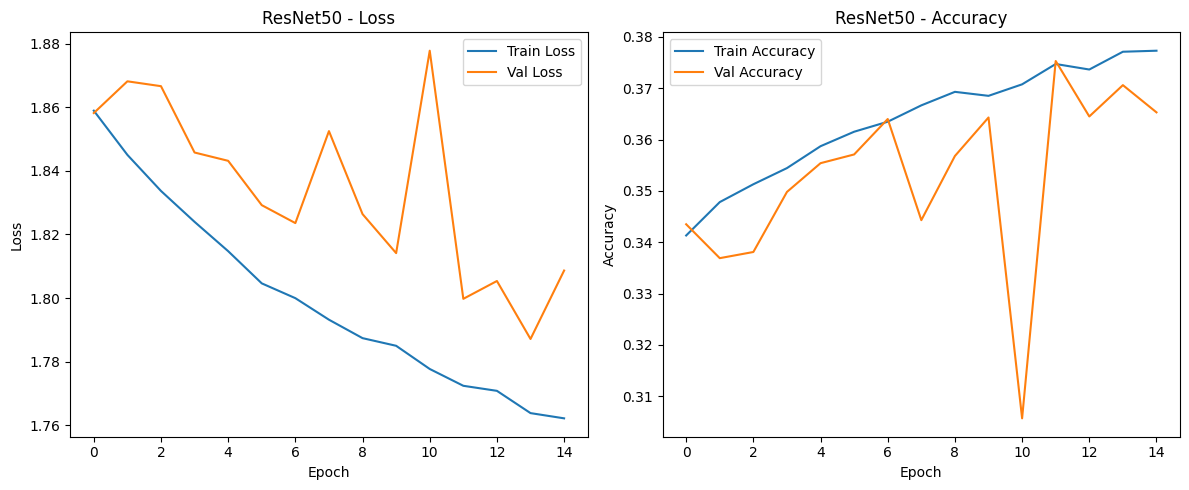

469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


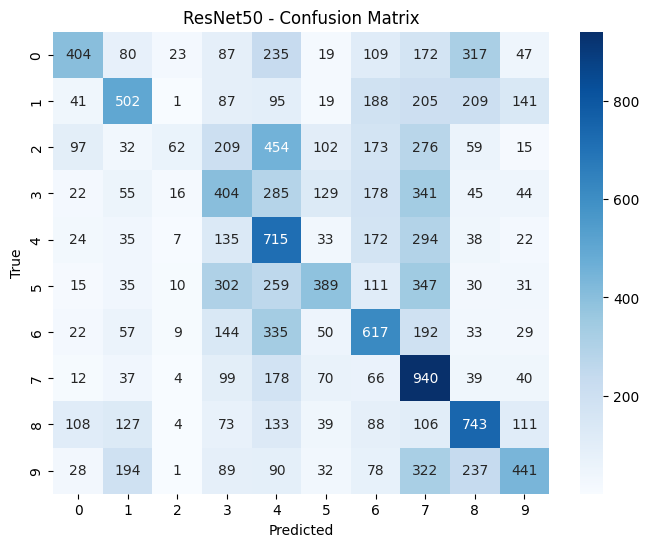

ResNet50 - Classification Report
              precision    recall  f1-score   support

           0       0.52      0.27      0.36      1493
           1       0.44      0.34      0.38      1488
           2       0.45      0.04      0.08      1479
           3       0.25      0.27      0.26      1519
           4       0.26      0.48      0.34      1475
           5       0.44      0.25      0.32      1529
           6       0.35      0.41      0.38      1488
           7       0.29      0.63      0.40      1485
           8       0.42      0.48      0.45      1532
           9       0.48      0.29      0.36      1512

    accuracy                           0.35     15000
   macro avg       0.39      0.35      0.33     15000
weighted avg       0.39      0.35      0.33     15000

ROC AUC Score (OvA): 0.8030


In [ ]:
plot_history(history_resnet50, "ResNet50")
evaluate_predictions(resnet50_tl, test_images, y_test_cat, "ResNet50")

#ResNet-152

In [ ]:
resnet152_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet152 = resnet152_tl.fit(train_images, y_train_cat, epochs=5,
                                validation_data=(val_images, y_val_cat), batch_size=BATCH_SIZE)

# Evaluation
resnet152_tl.evaluate(test_images, y_test_cat)

Epoch 1/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 73s 61ms/step - accuracy: 0.1450 - loss: 2.2898 - val_accuracy: 0.2112 - val_loss: 2.1856
Epoch 2/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - accuracy: 0.2102 - loss: 2.1789 - val_accuracy: 0.2371 - val_loss: 2.1483
Epoch 3/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.2316 - loss: 2.1403 - val_accuracy: 0.2224 - val_loss: 2.1399
Epoch 4/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.2398 - loss: 2.1214 - val_accuracy: 0.2356 - val_loss: 2.1197
Epoch 5/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.2450 - loss: 2.1096 - val_accuracy: 0.2487 - val_loss: 2.1136
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.2354 - loss: 2.1541


[2.150887966156006, 0.2295999974012375]

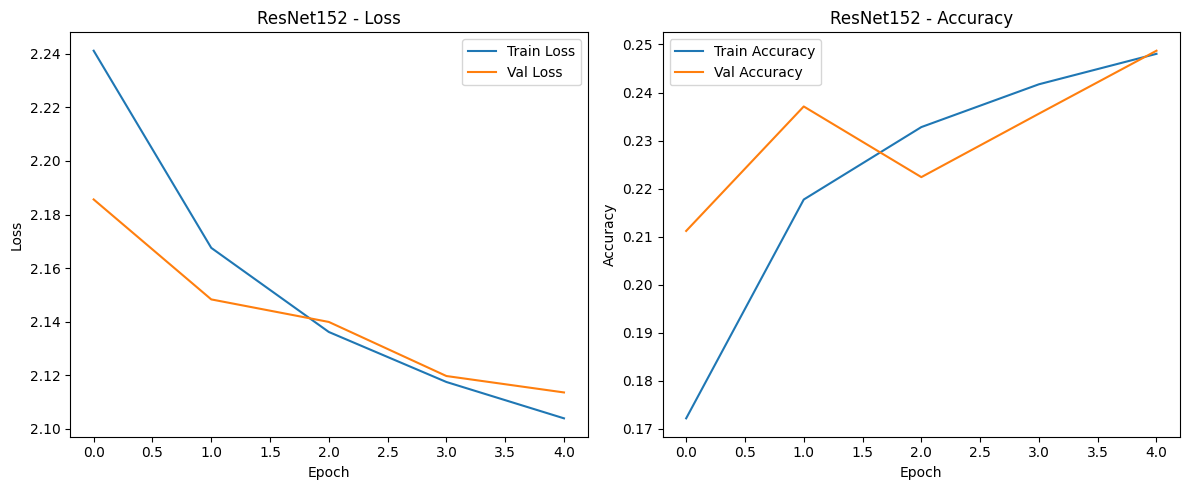

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step


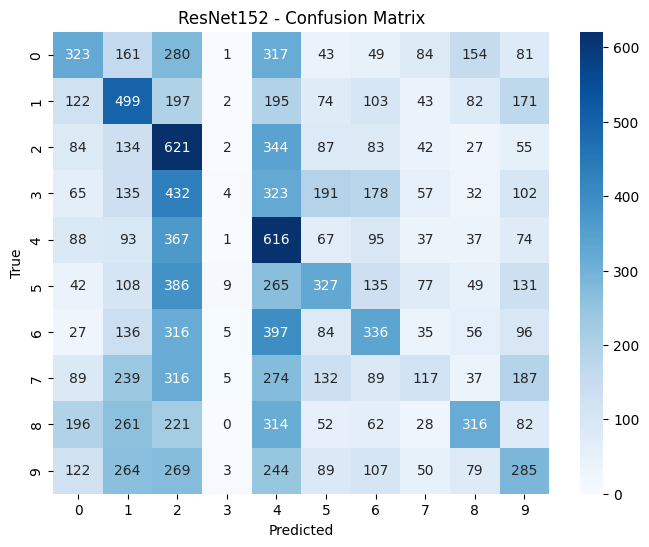

ResNet152 - Classification Report
              precision    recall  f1-score   support

           0       0.28      0.22      0.24      1493
           1       0.25      0.34      0.28      1488
           2       0.18      0.42      0.25      1479
           3       0.12      0.00      0.01      1519
           4       0.19      0.42      0.26      1475
           5       0.29      0.21      0.24      1529
           6       0.27      0.23      0.25      1488
           7       0.21      0.08      0.11      1485
           8       0.36      0.21      0.26      1532
           9       0.23      0.19      0.21      1512

    accuracy                           0.23     15000
   macro avg       0.24      0.23      0.21     15000
weighted avg       0.24      0.23      0.21     15000

ROC AUC Score (OvA): 0.6930


In [ ]:
plot_history(history_resnet152, "ResNet152")
evaluate_predictions(resnet152_tl, test_images, y_test_cat, "ResNet152")